In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import awkward
import itertools
import time, sys
import matplotlib.colors
from IPython.display import clear_output
import scipy.optimize as optimization
import multiprocessing as mp
import functools
import tqdm

def update_progress(i, nfiles): #progress bar, just for show
    progress = i / nfiles
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "N Files to process = {0} \nProgress: [{1}] {2:.1f}%".format(nfiles, "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [ ]:
base_path541 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.1_PROD-1/202112/' #xmas ws bkg
runs541 = [6771,6772,6773,6774,6775,6776,6777,6778,6780,6782,6783,6784,6785]
files541 = []

base_pathPF = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-dev-ce3da583_PROD-0/202112/' #xmas ws bkg
runsPF = [6771,6772,6773,6774,6775,6776,6777,6778,6780,6782,6783,6784,6785]
filesPF = []

base_pathPFC = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-dev-6715023f_PROD-0/202112/' #xmas ws bkg
runsPFC = [6771,6772,6773,6774,6775,6776,6777,6778,6780,6782,6783,6784,6785]
filesPFC = []

base_path544 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.4_PROD-0/202112/' #xmas ws bkg
runs544 = [6771,6772,6773,6774,6775,6776,6777,6778,6780,6782,6783,6784,6785]
files544 = []

for run in runs541:
    files541.extend(glob.glob(base_path541 + '*{0:06d}/rq/*.root'.format(run)))
print(len(files541))

for run in runsPF:
    filesPF.extend(glob.glob(base_pathPF + '*{0:06d}/rq/*.root'.format(run)))
print(len(filesPF))

for run in runsPFC:
    filesPFC.extend(glob.glob(base_pathPFC + '*{0:06d}/rq/*.root'.format(run)))
print(len(filesPFC))

for run in runs544:
    files544.extend(glob.glob(base_path544 + '*{0:06d}/rq/*.root'.format(run)))
print(len(files544))

In [2]:
files545 = []
files546 = []

runs545 = '/global/cfs/cdirs/lz/users/grischbi/SR1_Calibration/tritium_April_545.list'
runs546 = '/global/cfs/cdirs/lz/users/grischbi/SR1_Calibration/tritium_April_546.list'

with open(runs545) as r545:
    lines545 = r545.readlines()
    lines545 = [line.rstrip() for line in lines545]

with open(runs546) as r546:
    lines546 = r546.readlines()
    lines546 = [line.rstrip() for line in lines546]
    
for file in lines545:
    files545.extend(glob.glob(file))
print(len(files545))
for file in lines546:
    files546.extend(glob.glob(file))
print(len(files546))

2451
2373


In [3]:
def scatters(thefile):    
    #get the pulse IDs for s1 and s2 in single scatters branch
    scatters = uproot.open(thefile)['Scatters']
    events = uproot.open(thefile)['Events']
    s1s = scatters.array('ss.s1Area_phd')
    nSS = scatters.array('ss.nSingleScatters')
    s1m = scatters.array('ms.s1Area_phd')
    nMS = scatters.array('ms.nMultipleScatters')
    runID = events.array('eventHeader.runID')
    eventID = events.array('eventHeader.eventID')
    
    isSS = nSS == 1
    runID = runID[isSS]
    eventID = eventID[isSS]
    s1SS = s1s[isSS]
    return s1s, s1m, nSS, nMS,runID,eventID,s1SS

In [ ]:
S1sarea541 = []
S1marea541 = []
nSS541 = []
nMS541 = []

S1sareaPF = []
S1mareaPF = []
nSSPF = []
nMSPF = []

S1sareaPFC = []
S1mareaPFC = []
nSSPFC = []
nMSPFC = []

S1sarea544 = []
S1marea544 = []
nSS544 = []
nMS544 = []

In [18]:
S1sarea545 = []
S1marea545 = []
nSS545 = []
nMS545 = []
EID545 = []
RID545 = []
S1ss545 = []

S1sarea546 = []
S1marea546 = []
nSS546 = []
nMS546 = []
EID546 = []
RID546 = []
S1ss546 = []

In [ ]:
nfiles = len(files545) # run the function over the list of files
for i, file in enumerate(files545):
    if file == "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/lz_202201221240_007152/rq/lz_007152_000062_rq.root":
            continue
    if file == "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/lz_202201221240_007152/rq/lz_007152_000063_rq.root":
            continue
    if file == "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/lz_202201230822_007160/rq/lz_007160_000072_rq.root":
            continue
    if file == "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/lz_202201231137_007161/rq/lz_007161_000023_rq.root":
            continue
    if file == "global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/lz_202201231137_007161/rq/lz_007161_000068_rq.root":
            continue
    if file == "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/lz_202201231137_007161/rq/lz_007161_000068_rq.root":
            continue
    s1s, s1m, nss,nMS = scatters(file) #we don't care about having the mask returned here
    S1sarea545.append(0)
    S1marea545.append(1)
    nSS545.append(2)
    nMS545.append(3)
    update_progress(i, nfiles)

In [5]:
with mp.Pool(16) as pool:
    results545 = list(tqdm.tqdm(pool.imap(functools.partial(scatters),files545)))   
    results546 = list(tqdm.tqdm(pool.imap(functools.partial(scatters),files546)))

2451it [04:35,  8.90it/s]
2373it [04:02,  9.78it/s]


In [ ]:
for i in results541:
    S1sarea541.append(i[0])
    S1marea541.append(i[1])
    nSS541.append(i[2])
    nMS541.append(i[3])
    
for i in resultsPF:
    S1sareaPF.append(i[0])
    S1mareaPF.append(i[1])
    nSSPF.append(i[2])
    nMSPF.append(i[3])
    
for i in resultsPFC:
    S1sareaPFC.append(i[0])
    S1mareaPFC.append(i[1])
    nSSPFC.append(i[2])
    nMSPFC.append(i[3])
    
for i in results544:
    S1sarea544.append(i[0])
    S1marea544.append(i[1])
    nSS544.append(i[2])
    nMS544.append(i[3])

In [19]:
for i in results545:
    S1sarea545.append(i[0])
    S1marea545.append(i[1])
    nSS545.append(i[2])
    nMS545.append(i[3])
    EID545.append(i[4])
    RID545.append(i[5])
    S1ss545.append(i[6])
for i in results546:
    S1sarea546.append(i[0])
    S1marea546.append(i[1])
    nSS546.append(i[2])
    nMS546.append(i[3])
    EID546.append(i[4])
    RID546.append(i[5])
    S1ss546.append(i[6])

In [ ]:
S1sarea541 = list(itertools.chain.from_iterable(S1sarea541))
S1marea541 = list(itertools.chain.from_iterable(S1marea541))
nSS541 = list(itertools.chain.from_iterable(nSS541))
nMS541 = list(itertools.chain.from_iterable(nMS541))

S1sareaPF = list(itertools.chain.from_iterable(S1sareaPF))
S1mareaPF = list(itertools.chain.from_iterable(S1mareaPF))
nSSPF = list(itertools.chain.from_iterable(nSSPF))
nMSPF = list(itertools.chain.from_iterable(nMSPF))

S1sareaPFC = list(itertools.chain.from_iterable(S1sareaPFC))
S1mareaPFC = list(itertools.chain.from_iterable(S1mareaPFC))
nSSPFC = list(itertools.chain.from_iterable(nSSPFC))
nMSPFC = list(itertools.chain.from_iterable(nMSPFC))

S1sarea544 = list(itertools.chain.from_iterable(S1sarea544))
S1marea544 = list(itertools.chain.from_iterable(S1marea544))
nSS544 = list(itertools.chain.from_iterable(nSS544))
nMS544 = list(itertools.chain.from_iterable(nMS544))

In [20]:
S1sarea545 = list(itertools.chain.from_iterable(S1sarea545))
S1marea545 = list(itertools.chain.from_iterable(S1marea545))
nSS545 = list(itertools.chain.from_iterable(nSS545))
nMS545 = list(itertools.chain.from_iterable(nMS545))
EID545 = list(itertools.chain.from_iterable(EID545))
RID545 = list(itertools.chain.from_iterable(RID545))
S1ss545 = list(itertools.chain.from_iterable(S1ss545))

S1sarea546 = list(itertools.chain.from_iterable(S1sarea546))
S1marea546 = list(itertools.chain.from_iterable(S1marea546))
nSS546 = list(itertools.chain.from_iterable(nSS546))
nMS546 = list(itertools.chain.from_iterable(nMS546))
EID546 = list(itertools.chain.from_iterable(EID546))
RID546 = list(itertools.chain.from_iterable(RID546))
S1ss546 = list(itertools.chain.from_iterable(S1ss546))


In [21]:
print(len(RID545))
print(len(EID545))
print(len(EID546))
print(len(S1ss545))

798169
798169
789683
798169


In [10]:
print(EID545[0:10])
print(S1ss545[0:10])

[8121, 8121, 8121, 8121, 8121, 8121, 8121, 8121, 8121, 8121]
[421.71597, 9075.747, 1140.4045, 948.74646, 1000.25476, 4617.968, 4642.934, 224.04747, 2952.599, 862.027]


In [47]:
S1max545 = np.array(S1ss545) < 100
CutEID545 = np.array(EID545)
CutRID545 = np.array(RID545)
CutS1ss545 = np.array(S1ss545)

CutEID545 = CutEID545[S1max545]
CutRID545 = CutRID545[S1max545]
CutS1ss545  = CutS1ss545[S1max545]

S1min545 = np.array(CutS1ss545) > 10
CutEID545 = CutEID545[S1min545]
CutRID545 = CutRID545[S1min545]
CutS1ss545  = CutS1ss545[S1min545]

In [48]:
S1max546 = np.array(S1ss546) < 100
CutEID546 = np.array(EID546)
CutRID546 = np.array(RID546)
CutS1ss546 = np.array(S1ss546)

CutEID546 = CutEID546[S1max546]
CutRID546 = CutRID546[S1max546]
CutS1ss546 = CutS1ss546[S1max546]

S1min546 = np.array(CutS1ss546) > 10
CutEID546 = CutEID546[S1min546]
CutRID546 = CutRID546[S1min546]
CutS1ss546  = CutS1ss546[S1min546]

In [49]:
print(len(CutEID545))
print(len(CutEID546))

29032
29764


In [50]:
Events546 = []
for i,(j,k) in enumerate(zip(CutRID546,CutEID546)):
     Events546.append((k,j))

In [51]:
Events546[0:10]

[(8122, 206),
 (8122, 213),
 (8122, 564),
 (8122, 581),
 (8122, 667),
 (8122, 1210),
 (8122, 1246),
 (8122, 1460),
 (8122, 1488),
 (8122, 2140)]

In [52]:
Events545 = []
for i,(j,k) in enumerate(zip(CutRID545,CutEID545)):
     Events545.append((k,j))

In [53]:
Events545[0:10]

[(8121, 182),
 (8121, 541),
 (8121, 558),
 (8121, 778),
 (8121, 798),
 (8121, 811),
 (8121, 838),
 (8121, 1371),
 (8121, 1443),
 (8121, 1797)]

In [54]:
notin546 = []
for i in Events545:
    if i not in (Events546):
        notin546.append(i)

In [55]:
print(len(notin546))

6042


In [56]:
notin546[0:20]

[(8121, 182),
 (8121, 541),
 (8121, 558),
 (8121, 778),
 (8121, 798),
 (8121, 811),
 (8121, 838),
 (8121, 1371),
 (8121, 1443),
 (8121, 1797),
 (8121, 2230),
 (8121, 3134),
 (8121, 3195),
 (8121, 3219),
 (8121, 3664),
 (8121, 3821),
 (8121, 3887),
 (8121, 3980),
 (8121, 4139),
 (8121, 4343)]

In [57]:
runs = []
events = []
for i in notin546:
    runs.append(i[0])
    events.append(i[1])

In [61]:
(8161, 71252) not in Events546

True

In [59]:
for i,j in zip(runs,events):
    print(i,j)

8121 182
8121 541
8121 558
8121 778
8121 798
8121 811
8121 838
8121 1371
8121 1443
8121 1797
8121 2230
8121 3134
8121 3195
8121 3219
8121 3664
8121 3821
8121 3887
8121 3980
8121 4139
8121 4343
8121 4763
8121 5011
8121 5035
8121 5082
8121 5535
8121 5620
8121 5627
8121 5682
8121 5699
8121 5896
8121 6330
8121 6663
8121 6785
8121 7730
8121 8436
8121 9113
8121 9198
8121 9217
8121 9283
8121 9325
8121 10571
8121 10728
8121 10774
8121 10948
8121 11252
8121 11725
8121 11996
8121 12935
8121 13019
8121 13354
8121 13364
8121 13890
8121 14713
8121 15229
8121 15245
8121 15249
8121 15255
8121 15260
8121 15282
8121 15284
8121 15300
8121 15307
8121 15345
8121 15673
8121 16164
8121 16350
8121 17009
8121 17237
8121 17701
8121 17856
8121 18142
8121 18428
8121 18539
8121 19024
8121 19046
8121 19310
8121 19356
8121 21041
8121 21177
8121 21805
8121 22342
8121 22382
8121 22422
8121 22608
8121 22873
8121 23059
8121 23297
8121 23485
8121 23768
8121 24322
8121 24339
8121 24422
8121 24501
8121 24875
8121 25076
81

In [ ]:
def get_rate( S1area ):
    rate = []
    sortS1 = sorted(S1area)
    minS1, maxS1, step = 10, 110, 5
    x = []
    nSSs = 0
    for i in range(len(sortS1)-1):
        if sortS1[i] < minS1:
            continue
        nSSs += 1
        if sortS1[i+1] >= minS1 + step:
            
            rate.append( nSSs)
            x.append( minS1 + step/2 )
            minS1 += step
            nSSs = 0
        if sortS1[i+1] > maxS1:
            break
            
    return x, rate

In [ ]:
xs541, rates541 = get_rate(S1sarea541)
xsPF, ratesPF = get_rate(S1sareaPF)
xsPFC, ratesPFC = get_rate(S1sareaPFC)
xs544, rates544 = get_rate(S1sarea544)

In [ ]:
xs545, rates545 = get_rate(S1sarea545)
xs546, rates546 = get_rate(S1sarea546)

In [ ]:
xm541, ratem541 = get_rate(S1marea541)
xmPF, ratemPF = get_rate(S1mareaPF)
xmPFC, ratemPFC = get_rate(S1mareaPFC)
xm544, ratem544 = get_rate(S1marea544)

In [ ]:
diffsPF = list(np.subtract(np.array(rates541), np.array(ratesPF)))
diffsPFC = list(np.subtract(np.array(rates541), np.array(ratesPFC)))
diffs544 = list(np.subtract(np.array(rates541), np.array(rates544)))

In [ ]:
diffmPF = list(np.subtract(np.array(ratem541), np.array(ratemPF)))
diffmPFC = list(np.subtract(np.array(ratem541), np.array(ratemPFC)))
diffm544 = list(np.subtract(np.array(ratem541), np.array(ratem544)))

In [ ]:
plt.plot( xs541, rates541, 'k-o', lw=2, ms=6 )
plt.plot( xsPF, ratesPF, 'r-o', lw=2, ms=6 )
plt.plot( xsPFC, ratesPFC, 'c-o', lw=2, ms=6 )
plt.plot( xs544, rates544, 'b-o', lw=2, ms=6 )
plt.xlabel('S1 [phd]', fontsize=18, family='serif' )
plt.ylabel(' Number of SS ', fontsize = 18, family='serif') 
plt.xticks( size=14, family='serif' )
plt.yticks( size=14, family='serif')
plt.yscale("log")
plt.tight_layout()
plt.show()

In [ ]:
plt.plot( xs545, rates545, 'k-o', lw=2, ms=6, label = '5.4.5' )
plt.plot( xs546, rates546, 'r-o', lw=2, ms=6, label = '5.4.6')
plt.title('SS Events for Tritium', fontsize=18, family='serif')
plt.xlabel('S1 [phd]', fontsize=18, family='serif' )
plt.ylabel(' Number of SS ', fontsize = 18, family='serif') 
plt.xticks( size=14, family='serif' )
plt.yticks( size=14, family='serif')
plt.yscale("log")
plt.tight_layout()
plt.legend(prop={'size': 10})
plt.show()

In [ ]:
plt.plot( xm541, ratem541, 'k-o', lw=2, ms=6 )
plt.plot( xmPF, ratemPF, 'r-o', lw=2, ms=6 )
plt.plot( xmPFC, ratemPFC, 'c-o', lw=2, ms=6 )
plt.plot( xm544, ratem544, 'b-o', lw=2, ms=6 )
plt.xlabel('S1 [phd]', fontsize=18, family='serif' )
plt.ylabel(' Number of MS ', fontsize = 18, family='serif') 
plt.xticks( size=14, family='serif' )
plt.yticks( size=14, family='serif')
plt.yscale("log")
plt.tight_layout()
plt.show()

In [ ]:
plt.plot( xsPF, diffsPF, 'r-o', lw=2, ms=6 )
plt.plot( xsPFC, diffsPFC, 'c-o', lw=2, ms=6 )
plt.plot( xs544, diffs544, 'b-o', lw=2, ms=6 )
plt.xlabel('S1 [phd]', fontsize=18, family='serif' )
plt.ylabel(' Change in SS ', fontsize = 18, family='serif') 
plt.xticks( size=14, family='serif' )
plt.yticks( size=14, family='serif')
#plt.yscale("log")
plt.ylim(-300,300)
plt.tight_layout()
plt.show()

In [ ]:
plt.plot( xmPF, diffmPF, 'r-o', lw=2, ms=6 )
plt.plot( xmPFC, diffmPFC, 'c-o', lw=2, ms=6 )
plt.plot( xm544, diffm544, 'b-o', lw=2, ms=6 )
plt.xlabel('S1 [phd]', fontsize=18, family='serif' )
plt.ylabel(' Change in SS ', fontsize = 18, family='serif') 
plt.xticks( size=14, family='serif' )
plt.yticks( size=14, family='serif')
#plt.yscale("log")
plt.ylim(-300,300)
plt.tight_layout()
plt.show()

Change of Prom Plots

In [ ]:
base_path545 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/' #xmas ws bkg
runs545 = range(7138,7179)
files545 = []

base_path546 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.6_PROD-0/202201/' #xmas ws bkg
runs546 = range(7138,7179)
files546 = []

for run in runs545:
    files545.extend(glob.glob(base_path545 + '*{0:06d}/rq/*.root'.format(run)))
print(len(files545))

for run in runs546:
    files546.extend(glob.glob(base_path546 + '*{0:06d}/rq/*.root'.format(run)))
print(len(files546))

In [ ]:
base_path4 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.4_PROD-0/202201/'# New Kr path
runs4 = [7090,7092,7093,7094] #DevKr runs
files = []
for run in runs4:
    files.extend(glob.glob(base_path4 + '*{0:06d}/rq/*.root'.format(run)))

In [ ]:
def pulsestats(thefile):
    events = uproot.open(thefile)['Events']
    eventsPID = events.array('pulsesTPC.pulseID')
    PA = events.array('pulsesTPC.pulseArea_phd')
    S1prob = events.array('pulsesTPC.s1Probability')
    S2prob = events.array('pulsesTPC.s2Probability')
    S1pid = events.array('pulsesTPC.s1PulseIDs')
    S2pid = events.array('pulsesTPC.s2PulseIDs')
    S1prom = events.array('pulsesTPC.prominentS1PulseIDs')
    S2prom = events.array('pulsesTPC.prominentS2PulseIDs')  

    S1s = PA[S1pid]
    S2s = PA[S2pid]
    promS1s = PA[S1prom]
    promS2s = PA[S2prom]
    
    return S1s, S2s, promS1s,promS2s

In [ ]:
S1s545 = []
S2s545 = []
promS1s545 = []
promS2s545 = []

S1s546 = []
S2s546 = []
promS1s546 = []
promS2s546 = []

In [ ]:
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files)))

In [ ]:
with mp.Pool(16) as pool:
    results545 = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files545)))   
    results546 = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files546)))

In [ ]:
for i in results545:
    S1s545.append(i[0])
    S2s545.append(i[1])
    promS1s545.append(i[2])
    promS2s545.append(i[3])
    
for i in results546:
    S1s546.append(i[0])
    S2s546.append(i[1])
    promS1s546.append(i[2])
    promS2s546.append(i[3])

In [ ]:
flatS1s545 = list(itertools.chain.from_iterable(S1s545))
flatpromS1s545 = list(itertools.chain.from_iterable(promS1s545))
flatS2s545 = list(itertools.chain.from_iterable(S2s545))
flatpromS2s545 = list(itertools.chain.from_iterable(promS2s545))
flatS1s545 = list(itertools.chain.from_iterable(flatS1s545))
flatpromS1s545 = list(itertools.chain.from_iterable(flatpromS1s545))
flatS2s545 = list(itertools.chain.from_iterable(flatS2s545))
flatpromS2s545 = list(itertools.chain.from_iterable(flatpromS2s545))


flatS1s546 = list(itertools.chain.from_iterable(S1s546))
flatpromS1s546 = list(itertools.chain.from_iterable(promS1s546))
flatS2s546 = list(itertools.chain.from_iterable(S2s546))
flatpromS2s546 = list(itertools.chain.from_iterable(promS2s546))
flatS1s546 = list(itertools.chain.from_iterable(flatS1s546))
flatpromS1s546 = list(itertools.chain.from_iterable(flatpromS1s546))
flatS2s546 = list(itertools.chain.from_iterable(flatS2s546))
flatpromS2s546 = list(itertools.chain.from_iterable(flatpromS2s546))

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n,bins,patches = plt.hist(flatS1s545,bins=np.logspace(np.log10(1),np.log10(1e6), 1000))
n1,bins1,patches1 = plt.hist(flatpromS1s545,bins=np.logspace(np.log10(1),np.log10(1e6), 1000))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('S1s') 
plt.xlabel('S1 [phd]') 
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n,bins,patches = plt.hist(flatS1s546,bins=np.logspace(np.log10(1),np.log10(1e6), 1000))
n1,bins1,patches1 = plt.hist(flatpromS1s546,bins=np.logspace(np.log10(1),np.log10(1e6), 1000))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('S1s') 
plt.xlabel('S1 [phd]') 
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n,bins,patches = plt.hist(flatS1s545,bins=np.logspace(np.log10(1),np.log10(1e6), 1000),color='goldenrod',label = 'LZap-5.4.5' )
n1,bins1,patches1 = plt.hist(flatS1s546,bins=np.logspace(np.log10(1),np.log10(1e6), 1000), color='midnightblue',label = 'LZap-5.4.6' )
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Tritium S1s Between Different LZap Versions',fontsize=20) 
plt.xlabel('S1 [phd]',fontsize=20) 
plt.ylabel('Counts',fontsize=20)
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n3,bins,patches = plt.hist(flatpromS1s545,bins=np.logspace(np.log10(1),np.log10(1e6), 1000),color='black',label = 'LZap-5.4.5' )
n4,bins1,patches1 = plt.hist(flatpromS1s546,bins=np.logspace(np.log10(1),np.log10(1e6), 1000), color='firebrick',label = 'LZap-5.4.6' )
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Tritium Prominent S1s Between Different LZap Versions',fontsize=20) 
plt.xlabel('S1 [phd]',fontsize=20) 
plt.ylabel('Counts',fontsize=20)
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
diffchange = n -n1

In [ ]:
diffchangeprom = n3 -n4

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.plot(np.logspace(np.log10(1),np.log10(1e6), 999),diffchange,linewidth=3.0,color = 'crimson')
plt.title('Tritium S1s lost between 5.4.5 and 5.4.6',fontsize=20) 
plt.xlabel('S1 [phd]',fontsize=20) 
ax.set_yscale('log')
ax.set_xscale('log')
#plt.ylabel('Rejected S1s [counts]',fontsize=20)
plt.xlim(1,1e3)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.plot(np.logspace(np.log10(1),np.log10(1e6), 999),diffchangeprom,linewidth=3.0,color = 'dodgerblue')
plt.title('Tritium Prominent S1s lost between 5.4.5 and 5.4.6',fontsize=20) 
plt.xlabel('S1 [phd]',fontsize=20) 
ax.set_yscale('log')
ax.set_xscale('log')
#plt.ylabel('Rejected S1s [counts]',fontsize=20)
plt.xlim(1,1e3)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n2,bins2,patches2 = plt.hist(flatS2s,bins=np.logspace(np.log10(1),np.log10(1e7), 1000),color='royalblue',alpha=0.5)
n3,bins3,patches3 = plt.hist(flatpromS2s,bins=np.logspace(np.log10(1),np.log10(1e7), 1000),color='firebrick',alpha=0.5)
plt.hist(flatS2s,bins=np.logspace(np.log10(1),np.log10(1e7), 1000),color='royalblue',histtype='step',linewidth=3,label = 'All S2s')
plt.hist(flatpromS2s,bins=np.logspace(np.log10(1),np.log10(1e7), 1000),color='firebrick',histtype='step',linewidth=3,label = 'Prominent S2s')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Prominent and Non-Prominent S2s',fontsize=20) 
plt.xlabel('S2 [phd]',fontsize=20) 
plt.ylabel('Counts',fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(80,1e7)
#plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
diffchanges2 = n2 - n3

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.plot(np.logspace(np.log10(1),np.log10(1e7), 999),diffchanges2,linewidth=3.0)
plt.title('Rejected S2s from Prominence Selection ',fontsize=20) 
plt.xlabel('S2 [phd]',fontsize=20) 
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('Rejected S2s [counts]',fontsize=20)
plt.xlim(80,1e6)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.savefig('RejectS2s.png')
plt.show()

AmLi Efficiency Study

In [232]:
thesimsfile1 = '/global/cfs/cdirs/lz/users/qxia/AmLi/BACCARAT-6.2.9_LZLAMA-3.2.1_PROD-0_AmLi_Pipe1Z700Activ1kBq_coreFVcut_eachS2withinFV_plots.root'
thesimsfile2 = '/global/cfs/cdirs/lz/users/qxia/AmLi/BACCARAT-6.2.9_LZLAMA-3.2.1_PROD-0_AmLi_Pipe2Z700Activ1kBq_coreFVcut_eachS2withinFV_plots.root'
thesimsfile3 = '/global/cfs/cdirs/lz/users/qxia/AmLi/BACCARAT-6.2.9_LZLAMA-3.2.1_PROD-0_AmLi_Pipe3Z700Activ1kBq_coreFVcut_eachS2withinFV_plots.root' #'/global/homes/m/mrw7816/llamapaca/run/AmLiEnergy/AmLiEnergyAnalysis_Sims_70cmREDO.root'

In [233]:
SimsFile1 = uproot.open(thesimsfile1)
SimsFile2 = uproot.open(thesimsfile2)
SimsFile3 = uproot.open(thesimsfile3)

In [234]:
SSenergy1 = SimsFile1["ss_ROI_Erecon_NR_WSFV_NeutronSelection_TruthEtrain"].numpy()#SimsFile["SSReconstructedEnergy"].numpy()
SSenergy2 = SimsFile2["ss_ROI_Erecon_NR_WSFV_NeutronSelection_TruthEtrain"].numpy()
SSenergy3 = SimsFile3["ss_ROI_Erecon_NR_WSFV_NeutronSelection_TruthEtrain"].numpy()

In [316]:
thedatafile = '/global/homes/m/mrw7816/AlpacaAnalysis/run/AmLiEnergy/AmLiEnergy_PFCIFdev_70cmdata.root'
the546file = '/global/homes/m/mrw7816/AlpacaAnalysis/run/AmLiEnergy/AmLiEnergy_546_70cmdata.root'

In [317]:

DataFile = uproot.open(thedatafile)
Data546File = uproot.open(the546file)

In [318]:
DataFile.values()

[<b'TH1F' b'Livetime' 0x155411d4f958>,
 <b'TH1F' b'MSReconstructedEnergy' 0x155414f1ca98>,
 <b'TH1F' b'MS_S1c' 0x155414f1ccc8>,
 <b'TH1F' b'MS_S1r' 0x155416d5aa98>,
 <b'TH1F' b'MS_S2c' 0x15541680a3b8>,
 <b'TH1F' b'MS_S2r' 0x15541680af48>,
 <b'TH1F' b'SSReconstructedEnergy' 0x155414e45ea8>,
 <b'TH1F' b'SS_S1' 0x155414e45958>,
 <b'TH1F' b'SS_S1c' 0x155414e45368>,
 <b'TH1F' b'SS_S2' 0x155414e45b88>,
 <b'TH1F' b'SS_S2c' 0x155414e45278>]

In [319]:
SSdataenergy = DataFile["SSReconstructedEnergy"].numpy()
SS546dataenergy = Data546File["SSReconstructedEnergy"].numpy()

In [320]:
DataLivetime = DataFile["Livetime"].numpy()
Data546Livetime = Data546File["Livetime"].numpy()

In [321]:
DataLivetime[0]

array([116007.08], dtype=float32)

In [339]:
Data546Livetime[0]

array([52035.887], dtype=float32)

In [322]:
SimsLivetime = 2562393.162#1603893.56#420168
(1e6*2998 * 0.02)/35

1713142.857142857

In [270]:
SSenergy = np.add(SSenergy1[0],SSenergy2[0],SSenergy3[0])/3

In [324]:
SimsRate = (SSenergy)*1.5#/SimsLivetime)*166560#*20460.277 #the 166560 is the total time in seconds of the May AmLi calib
DataRate = (SSdataenergy[0]/DataLivetime[0])*117720#*20460.277
Data546Rate = (SS546dataenergy[0]/Data546Livetime[0])*117720#*20460.277

In [325]:
SimError = np.sqrt(SimsRate)

In [326]:
DataError = np.sqrt(DataRate)
Data546Error = np.sqrt(Data546Rate)

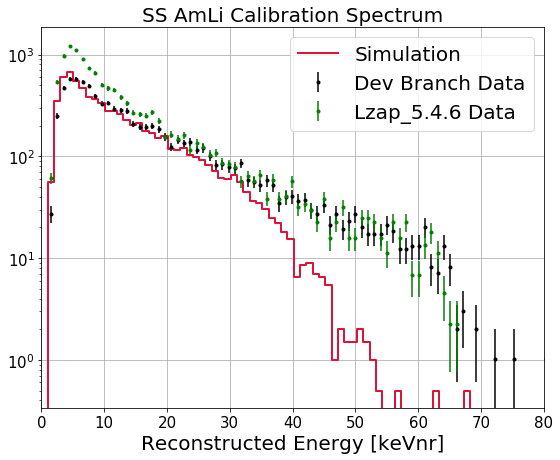

In [327]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
plt.step(y=SimsRate,x=np.linspace(0,200,200),color='crimson',linewidth=2,label='Simulation')
plt.errorbar(np.linspace(0,100,100)-0.5,DataRate,yerr=DataError,xerr=None,color='black',marker='.',linestyle='none',label='Dev Branch Data')
plt.errorbar(np.linspace(0,100,100)-0.5,Data546Rate,yerr=Data546Error,xerr=None,color='green',marker='.',linestyle='none',label='Lzap_5.4.6 Data')
ax.set_yscale('log')
#ax.set_xscale('log')
plt.title('SS AmLi Calibration Spectrum',fontsize=20) 
plt.xlim(0,80)
#plt.ylim(1,2e3)
plt.xlabel('Reconstructed Energy [keVnr]',fontsize=20) 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

In [195]:
Reconeff = DataRate/SimsRate

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [73]:
recerror = Reconeff*np.sqrt((DataError/DataRate)**2 + (SimError/SimsRate)**2)

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [74]:
errorbins = np.linspace(0,100,200)

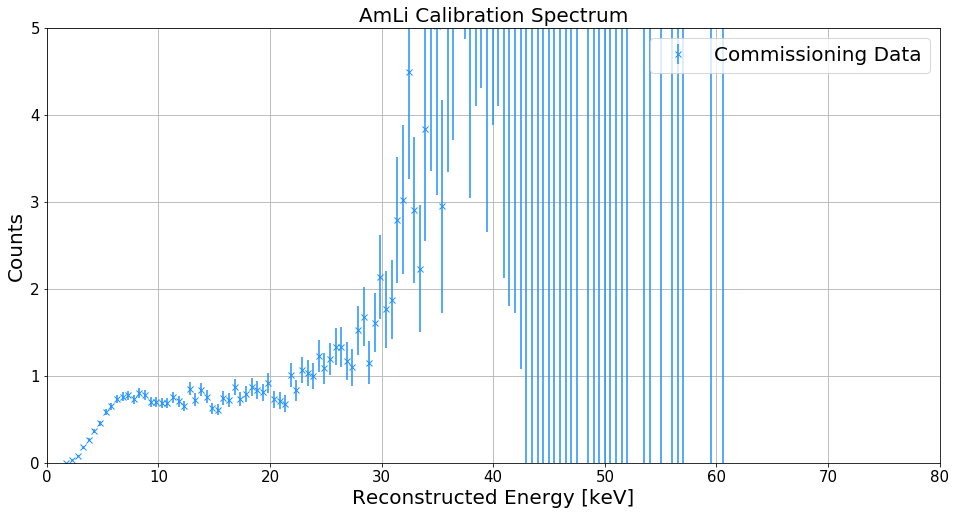

In [75]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.errorbar(np.linspace(0,100,200)+0.25,Reconeff,yerr=recerror,xerr=None,color='dodgerblue',marker='x',linestyle='none',label='Commissioning Data')
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.title('AmLi Calibration Spectrum',fontsize=20) 
plt.xlim(0,80)
plt.ylim(0,5)
plt.xlabel('Reconstructed Energy [keV]',fontsize=20) 
plt.ylabel('Counts',fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

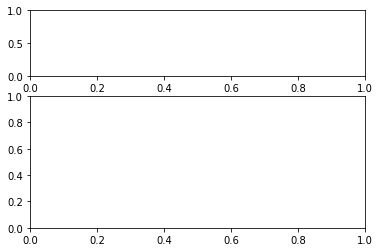

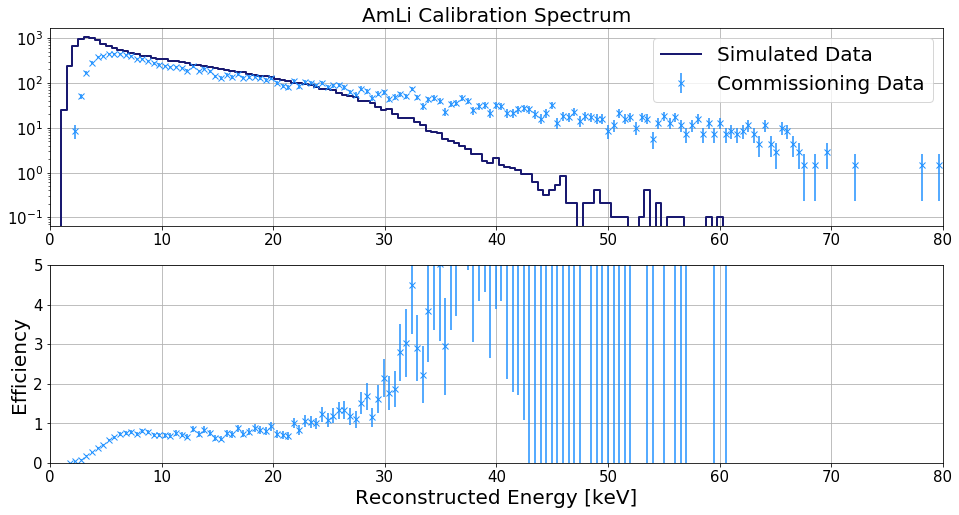

In [76]:
#fig = plt.figure(figsize=(16, 8))
#ax = fig.add_subplot(111)
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
plt.figure(figsize=(16, 8))
plt.subplot(2,1,1)
plt.step(y=SimsRate,x=np.linspace(0,100,200),color='midnightblue',linewidth=2,label='Simulated Data')
plt.errorbar(np.linspace(0,100,200)+0.25,DataRate,yerr=DataError,xerr=None,color='dodgerblue',marker='x',linestyle='none',label='Commissioning Data')
plt.yscale("log")
#ax.set_xscale('log')
plt.title('AmLi Calibration Spectrum',fontsize=20) 
plt.xlim(0,80)
#plt.xlabel('Reconstructed Energy [keV]',fontsize=20) 
#plt.ylabel('Counts',fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.legend(prop={'size': 20})

plt.subplot(2,1,2)
plt.errorbar(np.linspace(0,100,200)+0.25,Reconeff,yerr=recerror,xerr=None,color='dodgerblue',marker='x',linestyle='none',label='Commissioning Data')
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.title('AmLi Calibration Spectrum',fontsize=20) 
plt.xlim(0,80)
plt.ylim(0,5)
plt.xlabel('Reconstructed Energy [keV]',fontsize=20) 
plt.ylabel('Efficiency',fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)

plt.show()

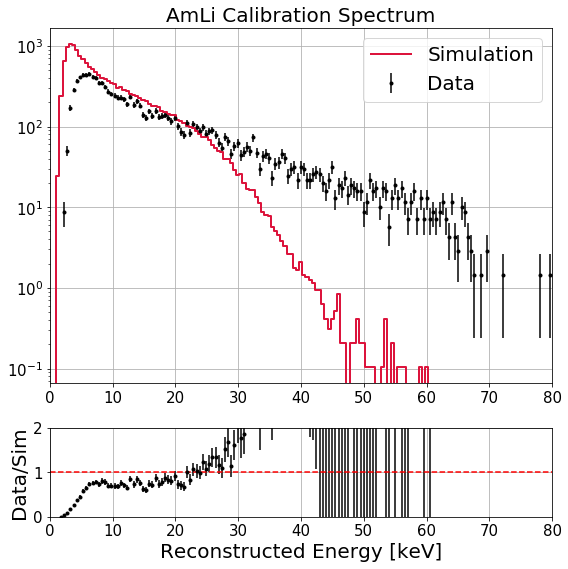

In [77]:
#fig = plt.figure(figsize=(16, 10))
#a0 = fig.add_subplot(211)
#ax1 = fig.add_subplot(212)
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]},figsize=(9, 9))
a0.step(y=SimsRate,x=np.linspace(0,100,200),color='crimson',linewidth=2,label='Simulation')
a0.errorbar(np.linspace(0,100,200)+0.25,DataRate,yerr=DataError,xerr=None,color='black',marker='.',linestyle='none',label='Data')
a0.set_yscale('log')
a0.set_title('AmLi Calibration Spectrum',fontsize=20) 
a0.set_xlim(0,80)
#plt.xlabel('Reconstructed Energy [keV]',fontsize=20) 
#plt.ylabel('Counts',fontsize=20)
a0.tick_params(axis='both', which='major', labelsize=15)
#a0.set_ytickslabels(fontsize = 15)
a0.grid(True)
a0.legend(prop={'size': 20})


a1.errorbar(np.linspace(0,100,200)+0.25,Reconeff,yerr=recerror,xerr=None,color='black',marker='.',linestyle='none',label='Commissioning Data')
#a1.set_yscale('log')
#ax.set_xscale('log')
#plt.title('AmLi Calibration Spectrum',fontsize=20) 
a1.set_xlim(0,80)
a1.set_ylim(0,2)
a1.set_xlabel('Reconstructed Energy [keV]',fontsize=20) 
a1.set_ylabel('Data/Sim',fontsize=20)
a1.tick_params(axis='both', which='major', labelsize=15)
a1.set_yticks([0,1,2], minor=False)
a1.axhline(y=1, color='r', linestyle='--')
a1.grid(True)

MS Analysis

In [328]:
MSenergy1 = SimsFile1["ms_ROI_Erecon_NR_WSFV_NeutronSelection_TruthEtrain"].numpy()#SimsFile["SSReconstructedEnergy"].numpy()
MSenergy2 = SimsFile2["ms_ROI_Erecon_NR_WSFV_NeutronSelection_TruthEtrain"].numpy()
MSenergy3 = SimsFile3["ms_ROI_Erecon_NR_WSFV_NeutronSelection_TruthEtrain"].numpy()
MSenergy = np.add(MSenergy1[0],MSenergy2[0],MSenergy3[0])/3
MSSimsRate = (MSenergy)*1.5
MSSimError = np.sqrt(MSSimsRate)


In [351]:
MSdataenergy = DataFile["MSReconstructedEnergy"].numpy()
MS546dataenergy = Data546File["MSReconstructedEnergy"].numpy()
MSDataRate = (MSdataenergy[0]/DataLivetime[0])*55000#*20460.277
MSData546Rate = (MS546dataenergy[0]/Data546Livetime[0])*55000#*20460.277
MSDataError = np.sqrt(MSDataRate)
MSData546Error = np.sqrt(MSData546Rate)

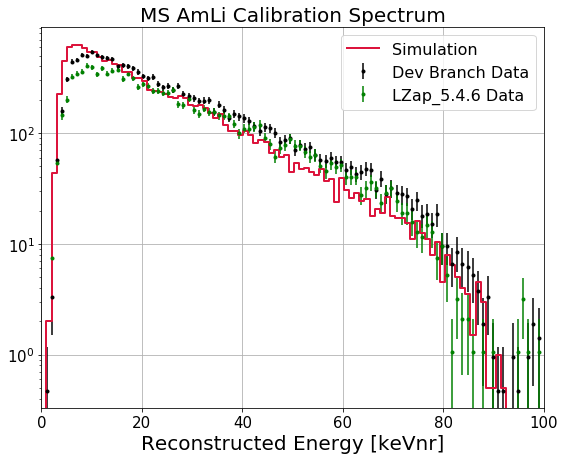

In [352]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
plt.step(y=MSSimsRate,x=np.linspace(0,200,200),color='crimson',linewidth=2,label='Simulation')
plt.errorbar(np.linspace(0,100,100),MSDataRate,yerr=MSDataError,xerr=None,color='black',marker='.',linestyle='none',label='Dev Branch Data')
plt.errorbar(np.linspace(0,100,100),MSData546Rate,yerr=MSData546Error,xerr=None,color='green',marker='.',linestyle='none',label='LZap_5.4.6 Data')
ax.set_yscale('log')
#ax.set_xscale('log')
plt.title('MS AmLi Calibration Spectrum',fontsize=20) 
plt.xlim(0,100)
plt.xlabel('Reconstructed Energy [keVnr]',fontsize=20) 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.legend(prop={'size': 16})
plt.show()

Change of Event classes

In [75]:
base_path1 = '/global/project/projectdirs/lz/data/reconstructed/SR1/LZAP-dev-1e22bed8_PROD-0/202205/'
runs1 = range(8288,8291)
files1 = []
base_path2 = '/global/project/projectdirs/lz/data/reconstructed/SR1/LZAP-5.4.6_PROD-0/202205/'
runs2 = range(8288,8291)
files2 = []

for run in runs1:
   files1.extend(glob.glob(base_path1 + '*{0:06d}/rq/*.root'.format(run)))
for run in runs2:
    files2.extend(glob.glob(base_path2 + '*{0:06d}/rq/*.root'.format(run)))
print(len(files1))
print(len(files2))

300
300


In [76]:
def pulsestats(thefile): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    nSS = scatters.array('ss.nSingleScatters')
    nMS = scatters.array('ms.nMultipleScatters')
    nPU = scatters.array('pileUp.nPileUpScatters')
    nO = scatters.array('other.nOtherScatters')
    return nSS,nMS,nPU,nO

In [85]:
nSSdev = []
nMSdev = []
nPUdev = []
nOdev = []

nSS546 = []
nMS546 = []
nPU546 = []
nO546 = []

In [78]:
with mp.Pool(16) as pool:
    resultsdev = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files1)))   
    results546 = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files2)))

300it [00:26, 11.43it/s]
300it [00:28, 10.47it/s]


In [86]:
for i in resultsdev:
    nSSdev.append(i[0])
    nMSdev.append(i[1])
    nPUdev.append(i[2])
    nOdev.append(i[3])

for i in results546:
    nSS546.append(i[0])
    nMS546.append(i[1])
    nPU546.append(i[2])
    nO546.append(i[3])

In [87]:
nSSdev = list(itertools.chain.from_iterable(nSSdev))
nMSdev = list(itertools.chain.from_iterable(nMSdev))
nPUdev = list(itertools.chain.from_iterable(nPUdev))
nOdev = list(itertools.chain.from_iterable(nOdev))
nSS546 = list(itertools.chain.from_iterable(nSS546))
nMS546 = list(itertools.chain.from_iterable(nMS546))
nPU546 = list(itertools.chain.from_iterable(nPU546))
nO546 = list(itertools.chain.from_iterable(nO546))

In [88]:
print(nSSdev.count(1))
print(nMSdev.count(1))
print(nPUdev.count(1))
print(nOdev.count(1))

print(nSS546.count(1))
print(nMS546.count(1))
print(nPU546.count(1))
print(nO546.count(1))

382866
277615
87850
151669
389991
274961
84737
150311


Energy range of DD handscan

In [ ]:
theDDfile = '/global/cfs/projectdirs/lz/users/sally/UCSB/PFC_Efficiency/SR1/SS_AbsEff_LZap_v5-4-4.root'

In [ ]:
#get the pulse IDs for s1 and s2 in single scatters branch
scatters = uproot.open(theDDfile)['Scatters']
s1c = scatters.array('ss.s1Area_phd')
s2c = scatters.array('ss.s2Area_phd')
nSS = scatters.array('ss.nSingleScatters')
g1 = 0.1045;
g2 = 60;
W = 13.55;    
E = ((s1c/g1 + s2c/g2)/W)**(1./1.1)

In [ ]:
E = E[np.logical_not(np.isnan(E))]

In [ ]:
E

In [ ]:
E.max()

In [ ]:
E.min()

In [ ]:
E.mean()

### 